## Setup

In [140]:
import pandas as pd
import time 
from queue import PriorityQueue
import face_recognition
from rtree import index
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree

## Load data

In [2]:
encodings = pd.read_csv('encodings.csv')

In [5]:
encodings.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_119,f_120,f_121,f_122,f_123,f_124,f_125,f_126,f_127,Path
0,-0.169392,0.047921,0.010893,-0.011651,-0.109157,-0.028991,0.015016,-0.073575,0.173696,0.018215,...,0.031502,0.031126,0.034204,-0.059601,-0.075313,0.055213,-0.074288,0.099157,0.049194,Tyler_Hamilton_0002.jpg
1,-0.139941,0.007571,-0.014323,-0.062974,-0.120753,-0.037069,0.017437,-0.093717,0.116224,0.010887,...,0.024384,-0.052877,0.011544,-0.120563,-0.085400,0.055733,-0.059825,0.111627,0.049313,Tyler_Hamilton_0001.jpg
2,-0.127995,0.123364,0.108196,-0.104053,-0.152023,0.001612,-0.092180,-0.040231,0.167982,-0.033269,...,0.060184,-0.032465,0.068416,-0.104261,-0.158331,-0.041461,-0.113930,0.025700,0.015137,Bernard_Siegel_0001.jpg
3,-0.115580,0.023755,0.116048,-0.092478,-0.048152,-0.032616,0.044573,-0.109533,0.131399,-0.131216,...,0.096097,-0.048958,0.029931,-0.188923,-0.108904,0.125606,0.012225,-0.037311,-0.012891,Blythe_Danner_0002.jpg
4,-0.077834,0.044584,0.092780,-0.095081,-0.083468,-0.051383,-0.011936,-0.077081,0.185955,-0.124233,...,0.101364,-0.080566,-0.038539,-0.250099,-0.036070,0.100281,0.050473,-0.035588,0.049188,Blythe_Danner_0001.jpg


In [6]:
print(f"Images size: {len(encodings)}")

Images size: 13171


### PCA Preprocessing

In [125]:
encodings_values = encodings.iloc[:, :-1].values
scaler = StandardScaler()
scaler.fit(encodings_values)
encodings_normalized = scaler.transform(encodings_values)

In [133]:
pca_dims = 64
pca = PCA(n_components=pca_dims)
pca.fit(encodings_normalized)
encodings_pca = pca.transform(encodings_normalized)
encodings_pca = pd.DataFrame(data = encodings_pca, columns=[f"PCA{i}" for i in range(pca_dims)])
encodings_pca = pd.concat([encodings_pca, encodings[['Path']]], axis = 1)

In [134]:
encodings_pca.head()

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,...,PCA55,PCA56,PCA57,PCA58,PCA59,PCA60,PCA61,PCA62,PCA63,Path
0,0.276125,-1.634108,-0.220236,-0.033463,3.525278,0.430656,-0.004932,2.210247,-0.015655,0.774366,...,-0.634998,0.763023,-0.130905,-1.534565,0.743891,-0.624016,0.410630,0.260722,0.142465,Tyler_Hamilton_0002.jpg
1,-0.828039,-1.816086,-0.042315,-0.029124,1.558967,-0.061827,1.217741,3.040335,-0.908122,0.236509,...,-0.446044,-0.081588,-0.336227,-0.187629,0.921209,-0.547294,0.080851,0.072201,-0.338521,Tyler_Hamilton_0001.jpg
2,-2.000564,-2.260950,-1.776624,1.113663,0.892776,-3.550203,-0.736039,-1.305400,0.910447,0.499271,...,0.658733,0.197559,-0.528441,0.737916,0.587256,0.174700,-0.284853,0.873437,-1.226682,Bernard_Siegel_0001.jpg
3,4.710906,-3.047256,3.130090,-2.713490,-1.824686,1.112081,1.378784,1.121711,0.689628,-1.465696,...,0.369740,-0.536570,-0.376807,1.896538,-1.419177,0.566983,0.183711,0.073704,0.386002,Blythe_Danner_0002.jpg
4,5.613315,-2.298624,2.099629,-2.508082,-1.343853,0.761871,0.043622,0.754333,-0.189728,0.196913,...,0.734845,-1.445203,-1.260773,1.207771,-1.357958,0.269239,0.489465,-1.259225,0.293521,Blythe_Danner_0001.jpg


## Creating RTree Index

In [139]:
index_property = index.Property()
index_property.dimension = 128
index_property.buffering_capacity = 3
index_property.dat_extension = 'data'
index_property.idx_extension = 'index'

index_property_pca = index.Property()
index_property_pca.dimension = pca_dims
index_property_pca.buffering_capacity = 3
index_property_pca.dat_extension = 'data'
index_property_pca.idx_extension = 'index'


def generate_index(n = -1):
    if n != -1:
        idx = index.Index(f"indexes/encodings_index_{n}", properties=index_property)
    else:
        idx = index.Index(f"indexes/encodings_index", properties=index_property)
    values = encodings.iloc[:, :-1].values.tolist()
    for i, value in enumerate(values): 
        if n == i and n != -1:
            break
        idx.insert(i, tuple(value))

def generate_index_pca(n =-1):
    if n != -1:
        idx = index.Index(f"indexes/encodings_index_{n}_pca", properties=index_property_pca)
    else:
        idx = index.Index(f"indexes/encodings_index_pca", properties=index_property_pca)
    values = encodings_pca.iloc[:, :-1].values.tolist()
    for i, value in enumerate(values): 
        if n == i and n != -1:
            break
        idx.insert(i, tuple(value))

In [ ]:
generate_index()
generate_index(100)
generate_index(200)
generate_index(400)
generate_index(800)
generate_index(1600)
generate_index(3200)
generate_index(6400)
generate_index(12800)

In [137]:
generate_index_pca()
generate_index_pca(100)
generate_index_pca(200)
generate_index_pca(400)
generate_index_pca(800)
generate_index_pca(1600)
generate_index_pca(3200)
generate_index_pca(6400)
generate_index_pca(12800)

## Funciones Útiles

In [4]:
def show_original_with_similars(image, similars):
    """
    Shows the original image with the similars
    """
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    from mpl_toolkits.axes_grid1 import ImageGrid

    # Load the image
    print("Real face")
    img = mpimg.imread(image)
    imgplot = plt.imshow(img)
    plt.show()

    # Load the image
    similar_images = []
    names = []
    for similar in similars:
        dir_name = similar[:-9]
        image = mpimg.imread(f"./dataset/{dir_name}/{similar}")
        similar_images.append(image)
        names.append(similar[:-9])

    # Create the plot
    print("Similar faces")
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
            
    for ax, im in zip(grid, similar_images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

    # Show the plot
    plt.show()

In [179]:
def run_experiment(image_name, knn_func, n = -1, k = 8, show_images = True, pca_ = False):
    image = face_recognition.load_image_file(image_name)
    faces = face_recognition.face_encodings(image)

    start = time.time()
    if pca_:
        face_norm = scaler.transform(faces[0].reshape(1, -1))
        face_pca = pca.transform(face_norm)
        if knn_func.__name__ == "KNN_rtree":
            res = knn_func(face_pca[0], k, encodings_pca.iloc[:, :-1].values.tolist(), n, pca_)
        else:
            res = knn_func(face_pca[0], k, encodings_pca.iloc[:, :-1].values.tolist(), n)

    else:
        res = knn_func(faces[0], k, encodings.iloc[:, :-1].values.tolist(), n)
    end = time.time()
    elapsed_time = round(end - start, 2)

    print("---------------------------------------------------------")
    print(f"Experimento N: {n}, K: {k}")
    print(f"Los 3 más parecidos son: {encodings.iloc[res[0], -1]}, {encodings.iloc[res[1], -1]}, {encodings.iloc[res[2], -1]}")
    print("La consulta tomó:", elapsed_time, "segundos")
    if show_images:
        show_original_with_similars(image_name, [encodings.iloc[res[0], -1], encodings.iloc[res[1], -1], encodings.iloc[res[2], -1]])

## KNN Algorithms

### KNN_Search

In [7]:
ED = lambda X, Y: (sum( ( X - Y ) ** 2 ) ) ** 0.5

def KNN_search(Q, k, data, n = -1):
    result = []
    q = PriorityQueue()
    for index, row in enumerate(data):
        dist = ED(Q, row)
        q.put((dist, index))
        if n != -1 and index == n:
            break
     
    result = list(q.queue)
    result_indexes = [x[1] for x in result]
    return result_indexes[:k]



### KNN_RTree

In [147]:
def KNN_rtree(Q, k, data = [], n = -1, pca_ = False):
    if n != -1:
        index_name = f"indexes/encodings_index_{n}"
    else:
        index_name = f"indexes/encodings_index"
    
    if pca_:
        index_name += "_pca"
        idx = index.Index(index_name, properties=index_property_pca)
    else:
        idx = index.Index(index_name, properties=index_property)
        
    res = list(idx.nearest(coordinates=tuple(Q), num_results=k))
    return res


### KNN-HighD

In [153]:
def KNN_KDTree(Q, k, data, n = -1):
    if n != -1:
        kd_tree = KDTree(data[:n])
    else:
        kd_tree = KDTree(data)
    
    result = kd_tree.query([Q], k)
    return result[1][0]

## Experimentos

In [180]:
query_images_path = "query_images"
query_image_file = f"{query_images_path}/renato.jpeg"

### KNN_Search Experimento

In [175]:
run_experiment(query_image_file, KNN_search, 100, 8, False)

---------------------------------------------------------
Experimento N: 100, K: 8
Los 3 más parecidos son: Adam_Herbert_0001.jpg, Gene_Robinson_0001.jpg, Gene_Robinson_0003.jpg
La consulta tomó: 0.09 segundos


In [167]:
run_experiment(query_image_file, KNN_search, 200, 8, False)
run_experiment(query_image_file, KNN_search, 400, 8, False)
run_experiment(query_image_file, KNN_search, 800, 8, False)
run_experiment(query_image_file, KNN_search, 1600, 8, False)
run_experiment(query_image_file, KNN_search, 3200, 8, False)
run_experiment(query_image_file, KNN_search, 6400, 8, False)
run_experiment(query_image_file, KNN_search, 12800, 8, False)

---------------------------------------------------------
Experimento N: 200, K: 8
Los 3 más parecidos son: Adam_Herbert_0001.jpg, Gene_Robinson_0001.jpg, Gene_Robinson_0003.jpg
La consulta tomó: 0.09 segundos
---------------------------------------------------------
Experimento N: 400, K: 8
Los 3 más parecidos son: Yasushi_Chimura_0001.jpg, Xanana_Gusmao_0002.jpg, Adam_Herbert_0001.jpg
La consulta tomó: 0.18 segundos
---------------------------------------------------------
Experimento N: 800, K: 8
Los 3 más parecidos son: Eddy_Merckx_0002.jpg, Yasushi_Chimura_0001.jpg, Mario_Jardel_0001.jpg
La consulta tomó: 0.17 segundos
---------------------------------------------------------
Experimento N: 1600, K: 8
Los 3 más parecidos son: Carlos_Quintanilla_Schmidt_0002.jpg, Florencia_Kirchner_0001.jpg, Gerardo_Gambala_0002.jpg
La consulta tomó: 0.14 segundos
---------------------------------------------------------
Experimento N: 3200, K: 8
Los 3 más parecidos son: Ernesto_Zedillo_0002.jpg, H

### KNN_rtree Experimento

In [174]:
run_experiment(query_image_file, KNN_rtree, 100, 8, False)

---------------------------------------------------------
Experimento N: 100, K: 8
Los 3 más parecidos son: Adam_Herbert_0001.jpg, Gene_Robinson_0003.jpg, Ralph_Sampson_0001.jpg
La consulta tomó: 0.08 segundos


In [170]:
run_experiment(query_image_file, KNN_rtree, 200, 8, False)
run_experiment(query_image_file, KNN_rtree, 400, 8, False)
run_experiment(query_image_file, KNN_rtree, 800, 8, False)
run_experiment(query_image_file, KNN_rtree, 1600, 8, False)
run_experiment(query_image_file, KNN_rtree, 3200, 8, False)
run_experiment(query_image_file, KNN_rtree, 6400, 8, False)
run_experiment(query_image_file, KNN_rtree, 12800, 8, False)

---------------------------------------------------------
Experimento N: 200, K: 8
Los 3 más parecidos son: Adam_Herbert_0001.jpg, Gene_Robinson_0003.jpg, Ralph_Sampson_0001.jpg
La consulta tomó: 0.16 segundos
---------------------------------------------------------
Experimento N: 400, K: 8
Los 3 más parecidos son: Yasushi_Chimura_0001.jpg, Xanana_Gusmao_0002.jpg, Michelle_Collins_0001.jpg
La consulta tomó: 0.12 segundos
---------------------------------------------------------
Experimento N: 800, K: 8
Los 3 más parecidos son: Eddy_Merckx_0002.jpg, Yasushi_Chimura_0001.jpg, Mario_Jardel_0001.jpg
La consulta tomó: 0.09 segundos
---------------------------------------------------------
Experimento N: 1600, K: 8
Los 3 más parecidos son: Carlos_Quintanilla_Schmidt_0002.jpg, Florencia_Kirchner_0001.jpg, Eddy_Merckx_0002.jpg
La consulta tomó: 0.1 segundos
---------------------------------------------------------
Experimento N: 3200, K: 8
Los 3 más parecidos son: Ernesto_Zedillo_0002.jpg, Ca

### KNN_KDTree Experimento

In [172]:
run_experiment(query_image_file, KNN_KDTree, 100, 8, False)

---------------------------------------------------------
Experimento N: 100, K: 8
Los 3 más parecidos son: Adam_Herbert_0001.jpg, Gene_Robinson_0003.jpg, Ralph_Sampson_0001.jpg
La consulta tomó: 0.08 segundos


In [171]:
run_experiment(query_image_file, KNN_KDTree, 200, 8, False)
run_experiment(query_image_file, KNN_KDTree, 400, 8, False)
run_experiment(query_image_file, KNN_KDTree, 800, 8, False)
run_experiment(query_image_file, KNN_KDTree, 1600, 8, False)
run_experiment(query_image_file, KNN_KDTree, 3200, 8, False)
run_experiment(query_image_file, KNN_KDTree, 6400, 8, False)
run_experiment(query_image_file, KNN_KDTree, 12800, 8, False)

---------------------------------------------------------
Experimento N: 200, K: 8
Los 3 más parecidos son: Adam_Herbert_0001.jpg, Gene_Robinson_0003.jpg, Ralph_Sampson_0001.jpg
La consulta tomó: 0.16 segundos
---------------------------------------------------------
Experimento N: 400, K: 8
Los 3 más parecidos son: Yasushi_Chimura_0001.jpg, Xanana_Gusmao_0002.jpg, Michelle_Collins_0001.jpg
La consulta tomó: 0.09 segundos
---------------------------------------------------------
Experimento N: 800, K: 8
Los 3 más parecidos son: Eddy_Merckx_0002.jpg, Yasushi_Chimura_0001.jpg, Mario_Jardel_0001.jpg
La consulta tomó: 0.1 segundos
---------------------------------------------------------
Experimento N: 1600, K: 8
Los 3 más parecidos son: Carlos_Quintanilla_Schmidt_0002.jpg, Florencia_Kirchner_0001.jpg, Eddy_Merckx_0002.jpg
La consulta tomó: 0.14 segundos
---------------------------------------------------------
Experimento N: 3200, K: 8
Los 3 más parecidos son: Ernesto_Zedillo_0002.jpg, Ca

### Visualizando consultas

---------------------------------------------------------
Experimento N: -1, K: 8
Los 3 más parecidos son: Ernesto_Zedillo_0002.jpg, Daniel_Montenegro_0001.jpg, Saeed_Anwar_0001.jpg
La consulta tomó: 0.49 segundos
Real face


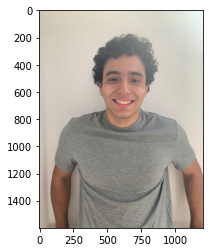

Similar faces


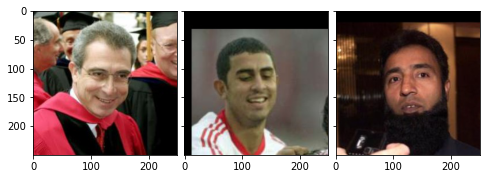

In [176]:
run_experiment("renato.jpeg", KNN_search, n=-1, k=8, show_images=True, pca_=False)

---------------------------------------------------------
Experimento N: -1, K: 8
Los 3 más parecidos son: Ernesto_Zedillo_0002.jpg, Daniel_Montenegro_0001.jpg, Saeed_Anwar_0001.jpg
La consulta tomó: 0.21 segundos
Real face


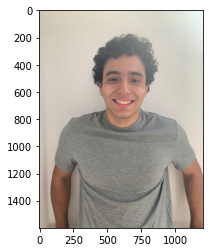

Similar faces


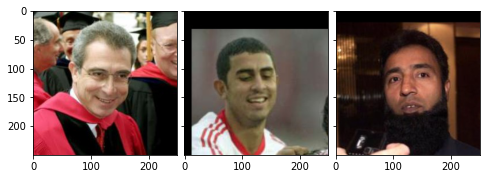

In [177]:
run_experiment("renato.jpeg", KNN_rtree, n=-1, k=8, show_images=True, pca_=False)

---------------------------------------------------------
Experimento N: -1, K: 8
Los 3 más parecidos son: Ernesto_Zedillo_0002.jpg, Daniel_Montenegro_0001.jpg, Saeed_Anwar_0001.jpg
La consulta tomó: 0.33 segundos
Real face


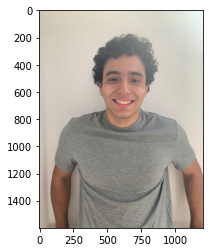

Similar faces


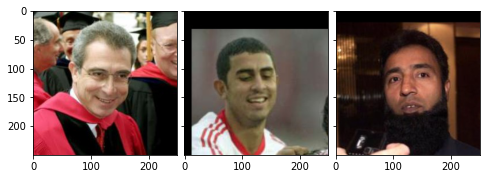

In [178]:
run_experiment("renato.jpeg", KNN_KDTree, n=-1, k=8, show_images=True, pca_=False)

### PCA Experimento

Experimento N=-1, K=8
Los 3 más parecidos son: Albert_Costa_0005.jpg, Ernesto_Zedillo_0002.jpg, Fabiola_Zuluaga_0001.jpg
La consulta tomó: 0.31 segundos
Real face


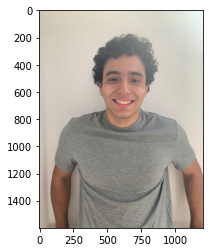

Similar faces


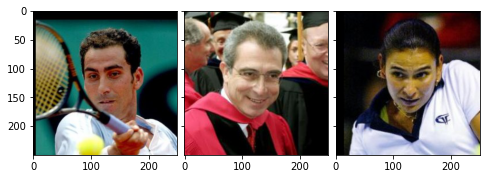

In [163]:
run_experiment(query_image_file, KNN_search, pca_=True)

Experimento N=-1, K=8
Los 3 más parecidos son: Albert_Costa_0005.jpg, Ernesto_Zedillo_0002.jpg, Andre_Agassi_0015.jpg
La consulta tomó: 0.1 segundos
Real face


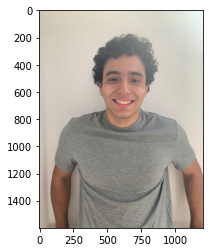

Similar faces


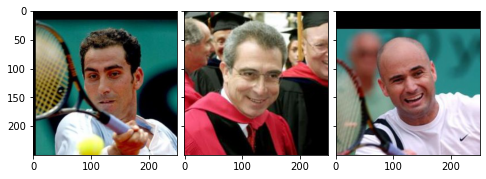

In [164]:
run_experiment(query_image_file, KNN_rtree, pca_=True)

Experimento N=-1, K=8
Los 3 más parecidos son: Albert_Costa_0005.jpg, Ernesto_Zedillo_0002.jpg, Andre_Agassi_0015.jpg
La consulta tomó: 0.17 segundos
Real face


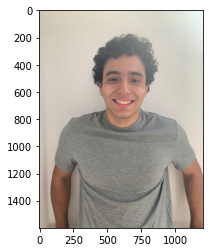

Similar faces


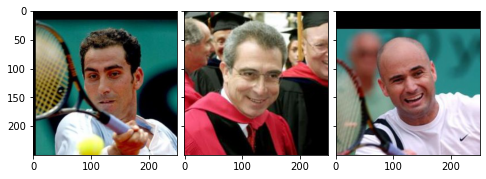

In [165]:

run_experiment(query_image_file, KNN_KDTree, pca_=True)

## Comparación

| Tiempo en segundos | KNN-Secuencial | KNN-RTree | KNN-HighD |
|--------------------|----------------|-----------|-----------|
| N = 100            | 0.09           | 0.08      | 0.08      |
| N = 200            | 0.09           | 0.16      | 0.16      |
| N = 400            | 0.18           | 0.12      | 0.09      |
| N = 800            | 0.17           | 0.0.09    | 0.1       |
| N = 1600           | 0.14           | 0.1       | 0.14      |
| N = 3200           | 0.19           | 0.09      | 0.13      |
| N = 6400           | 0.29           | 0.1       | 0.18      |
| N = 12800          | 0.6            | 0.12      | 0.33      |